In [1]:
# install fastkaggle if not available
try: import fastkaggle, nbdev
except ModuleNotFoundError:
    !pip install -Uq fastkaggle nbdev

from fastkaggle import *

## Set up

In [2]:
comp = 'digit-recognizer'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
path

Path('../input/digit-recognizer')

In [4]:
from fastai.vision.all import *
import os
import seaborn as sns
#set_seed(42)

path.ls()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(#3) [Path('../input/digit-recognizer/sample_submission.csv'),Path('../input/digit-recognizer/train.csv'),Path('../input/digit-recognizer/test.csv')]

## Looking at the data

In [5]:
# Load the data
df_train = pd.read_csv(path/"train.csv")
df_test = pd.read_csv(path/"test.csv")

In [6]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


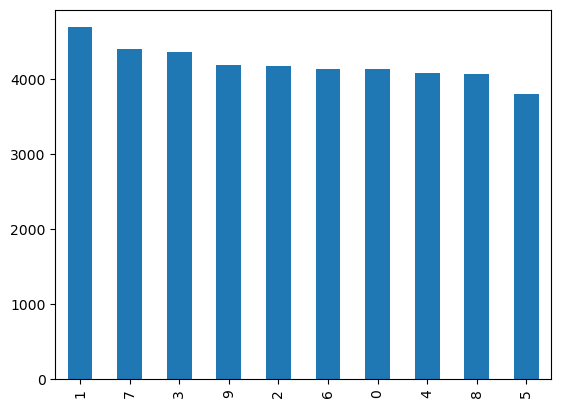

In [8]:
Y_train = df_train["label"]

# Drop 'label' column
X_train = df_train.drop(labels = ["label"],axis = 1) 

# free some space
#del train 

Y_train.value_counts().plot(kind='bar')
plt.show()

## Get data into the right format

This part I have adapted from https://www.kaggle.com/code/christianwallenwein/beginners-guide-to-mnist-with-fast-ai

In [9]:
! mkdir /kaggle/working/train
! mkdir /kaggle/working/test

In [10]:
TRAIN = Path("/kaggle/working/train")
TEST = Path("/kaggle/working/test")

# Create training directory
for index in range(10):
    try:
        os.makedirs(TRAIN/str(index))
    except:
        pass
# Test whether creating the training directory was successful
sorted(os.listdir(TRAIN))
#Create test directory
try:
    os.makedirs(TEST)
except:
    pass

In [11]:
def saveDigit(digit, filepath):
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)

    img = Image.fromarray(digit)
    img.save(filepath)
    
# save training images
for index, row in df_train.iterrows():
    
    label,digit = row[0], row[1:]
    
    folder = TRAIN/str(label)
    filename = f"{index}.jpg"
    filepath = folder/filename
    
    digit = digit.values
    
    saveDigit(digit, filepath)
    
# save testing images
for index, digit in df_test.iterrows():

    folder = TEST
    filename = f"{index}.jpg"
    filepath = folder/filename
    
    digit = digit.values
    
    saveDigit(digit, filepath)

## Check images

samples of training data


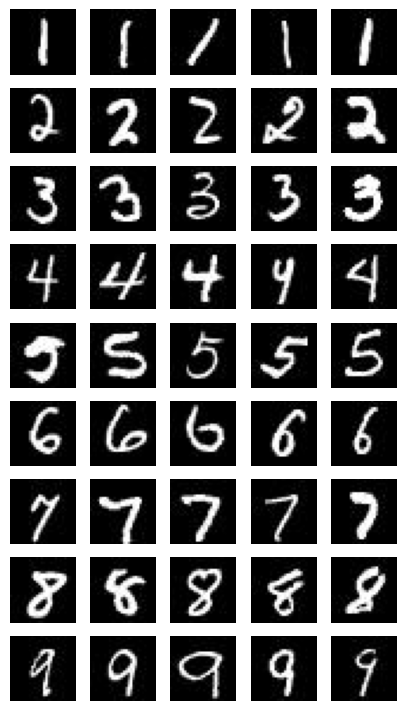

In [12]:
# import matplotlib to arrange the images properly
import matplotlib.pyplot as plt

def displayTrainingData():
    fig = plt.figure(figsize=(5,10))
    
    for rowIndex in range(1, 10):
        subdirectory = str(rowIndex)
        path = TRAIN/subdirectory
        images = os.listdir(path)
        for sampleIndex in range(1, 6):
            randomNumber = random.randint(0, len(images)-1)
            image = Image.open(path/images[randomNumber])
            ax = fig.add_subplot(10, 5, 5*rowIndex + sampleIndex)
            ax.axis("off")
            
            plt.imshow(image, cmap='gray')
        
    plt.show()
    
def displayTestingData():
    fig = plt.figure(figsize=(5, 10))
    
    paths = os.listdir(TEST)
    
        
    for i in range(1, 51):
        randomNumber = random.randint(0, len(paths)-1)
        image = Image.open(TEST/paths[randomNumber])
        
        ax = fig.add_subplot(10, 5, i)
        ax.axis("off")
        
        plt.imshow(image, cmap='gray')
    plt.show()
print('samples of training data')
displayTrainingData()

## Create data loader

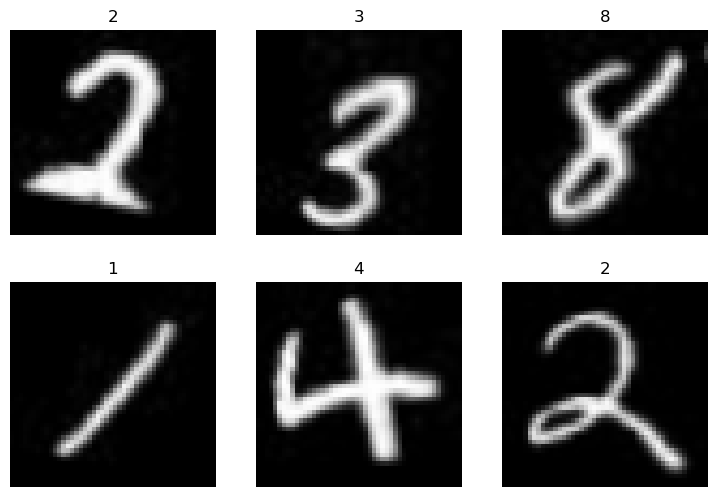

In [24]:
dls = ImageDataLoaders.from_folder(TRAIN, valid_pct=0.2,
                                   item_tfms=Resize(48, method='squish'),
                                   batch_tfms=aug_transforms(do_flip=False),
                                   bs=256)

dls.show_batch(max_n=6)

## First model

In [25]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=[error_rate, accuracy], path='.').to_fp16()

SuggestedLRs(valley=0.0063095735386013985, slide=0.02754228748381138)

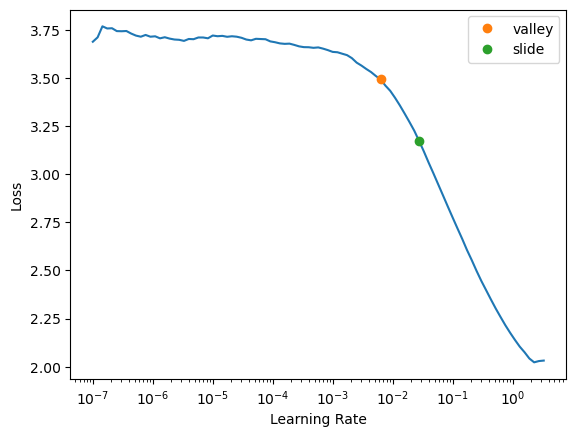

In [26]:
learn.lr_find(suggest_funcs=(valley, slide))

In [27]:
learn.fine_tune(3, 0.05)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.707231,0.109495,0.032143,0.967857,01:39


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.150166,0.060150,0.017738,0.982262,01:48
1,0.116301,0.050995,0.014286,0.985714,01:48
2,0.101676,0.047669,0.014048,0.985952,01:48


## Submitting to Kaggle

In [28]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [29]:
tst_files = get_image_files(TEST).sorted()
tst_dl = dls.test_dl(tst_files)

In [30]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([2, 0, 5,  ..., 2, 7, 7])

## Have a look at some predictions

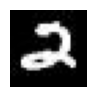

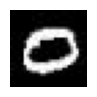

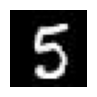

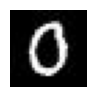

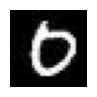

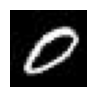

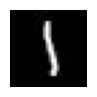

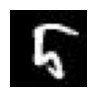

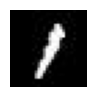

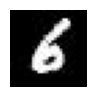

In [39]:
%matplotlib inline
files = get_image_files(TEST).sorted()
for i in range(10):
    img = PILImage.create(files[i])
    img.to_thumb(28)
    img.show()

In [74]:
order = []
for file in files:
    order.append(int(file.stem)+1)

In [75]:
ss['Label'] = list(idxs.numpy())
ss['ImageId'] = order 
ss.sort_values(by="ImageId", inplace=True)
ss

,ImageId,Label
0,1,2
1,2,0
1240,3,9
11363,4,0
12597,5,3
...,...,...
11108,27996,9
11109,27997,7
11110,27998,3
11111,27999,9


In [76]:
ss.to_csv('subm.csv', index=False)
!head subm.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


In [77]:
! rm -r /kaggle/working/test
! rm -r /kaggle/working/models
! rm -r /kaggle/working/train
